In [1]:
# Exploratory Data Analysis (IO-Bound)

# In this notebook I'll perform EDA to explain feature columns, 
# their relationships and overall everything we should know about the
# given dataset.

In [2]:
# Feature Columns

# time_ms = Timestamp of measurement in milliseconds

# cpu_psi_some_* = Shows how much time tasks are delayed because CPU is saturated. 

# cpu_psi_full_* = Percentage of time all non-idle tasks are stalled, waiting for CPU.  

# io_psi_some_* = Shows delay caused by storage / disk IO.

# io_psi_full_* = All runable tasks blocked on IO.

# mem_psi_some_* = Shows tasks waiting in memory.

# mem_psi_full_* = Shows all tasks stalled due to memory pressure.

# load_avg_* = Average number of runnable or IO-waiting tasks over time windows.

# procs_running = Number of processes currently runable.

# procs_blocked = Number of processes blocked waiting for IO completion.

# procs_disk_io = Processes specifically blocked on disk IO.

# Some -> At least 1 task waiting.
# Full -> Entire workload stalled.

In [3]:
# Imports

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [6]:
# Read CSV files

PROJECT_ROOT = Path.cwd().parent.parent
DATASET_DIR = PROJECT_ROOT / "datasets"
PRIO_DIR = DATASET_DIR / "prio-mem.csv"
RR_DIR = DATASET_DIR / "rr-mem.csv"

# Read
df_prio = pd.read_csv(PRIO_DIR)
df_rr = pd.read_csv(RR_DIR)

# Normalize column names (strip whitespace) so they align across files
df_prio.columns = df_prio.columns.str.strip()
df_rr.columns = df_rr.columns.str.strip()

# df_prio.head(5)
# df_rr.head(5)

In [7]:
# Add scheduler label
df_prio["scheduler"] = "PRIORITY"
df_rr["scheduler"] = "RR"

# Add ID for both
df_prio["id"] = df_prio.index + 1
df_rr["id"] = df_rr.index + 1

In [8]:
# Combine
df = pd.concat([df_prio, df_rr], ignore_index=True)

In [9]:
# Small check-up

df.head(5)

,time_ms,cpu_psi_some_10,cpu_psi_some_60,cpu_psi_some_300,cpu_psi_full_10,cpu_psi_full_60,cpu_psi_full_300,io_psi_some_10,io_psi_some_60,io_psi_some_300,...,mem_psi_full_60,mem_psi_full_300,load_avg_1,load_avg_5,load_avg_15,procs_running,procs_blocked,procs_disk_io,scheduler,id
0,0,7.84,2.64,0.69,0,0,0,0.07,0.41,0.15,...,0.0,0,3.90,1.03,0.35,16,0,0,PRIORITY,1
1,1000,9.14,3.05,0.79,0,0,0,0.06,0.40,0.15,...,0.0,0,3.90,1.03,0.35,8,0,0,PRIORITY,2
2,2000,9.14,3.05,0.79,0,0,0,0.06,0.40,0.15,...,0.0,0,4.31,1.16,0.40,8,0,0,PRIORITY,3
3,3000,9.48,3.31,0.86,0,0,0,0.04,0.38,0.15,...,0.0,0,4.31,1.16,0.40,7,0,0,PRIORITY,4
4,4000,9.48,3.31,0.86,0,0,0,0.04,0.38,0.15,...,0.0,0,4.31,1.16,0.40,7,0,0,PRIORITY,5


In [10]:
# Drop columns that have no information

for col in [
    "cpu_psi_full_10",
    "cpu_psi_full_60",
    "cpu_psi_full_300",
    "io_psi_some_10",
    "io_psi_full_10",
    "mem_psi_some_60",
    "mem_psi_full_300",
    "procs_disk_io",
    "procs_blocked"
    # TODO Check-up psi_some values for 10 and 60 are zero, but 300 is populated. Possible issue. Inspect mem csv files.
    ]:
    
    df = df.drop(col, axis=1)

In [11]:
# Basic Cleaning

# Sort by scheduler + time
df = df.sort_values(["scheduler", "time_ms"])

# Check missing
print(df.isna().sum())

time_ms             0
cpu_psi_some_10     0
cpu_psi_some_60     0
cpu_psi_some_300    0
io_psi_some_60      0
io_psi_some_300     0
io_psi_full_60      0
io_psi_full_300     0
mem_psi_some_10     0
mem_psi_some_300    0
mem_psi_full_10     0
mem_psi_full_60     0
load_avg_1          0
load_avg_5          0
load_avg_15         0
procs_running       0
scheduler           0
id                  0
dtype: int64


In [12]:
# Summary stats per scheduler

metrics = [c for c in df.columns if not c in ["time_ms", "scheduler", "id"]]

summary = df.groupby("scheduler")[metrics].agg([
    "mean",
    "std",
    "median",
    # TODO Add quantiles to summary
    "max"
])

print(summary)

          cpu_psi_some_10                         cpu_psi_some_60            \
                     mean       std median    max            mean       std   
scheduler                                                                     
PRIORITY        17.288092  2.200241  18.10  19.06       11.743206  3.867136   
RR              15.489417  3.436574  16.99  18.70        9.763500  4.030022   

                        cpu_psi_some_300            ... load_avg_5        \
          median    max             mean       std  ...     median   max   
scheduler                                           ...                    
PRIORITY   12.54  16.50         4.055954  1.828558  ...       2.91  4.47   
RR         10.30  15.18         3.270917  1.623089  ...       2.46  3.75   

          load_avg_15                        procs_running                   \
                 mean       std median   max          mean       std median   
scheduler                                                        

In [13]:
# TODO Spike / Stall Detection might be implemented if seen as necessary

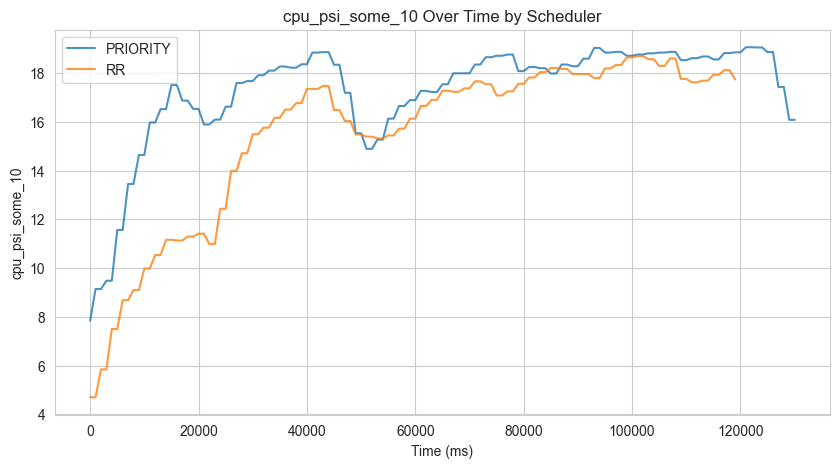

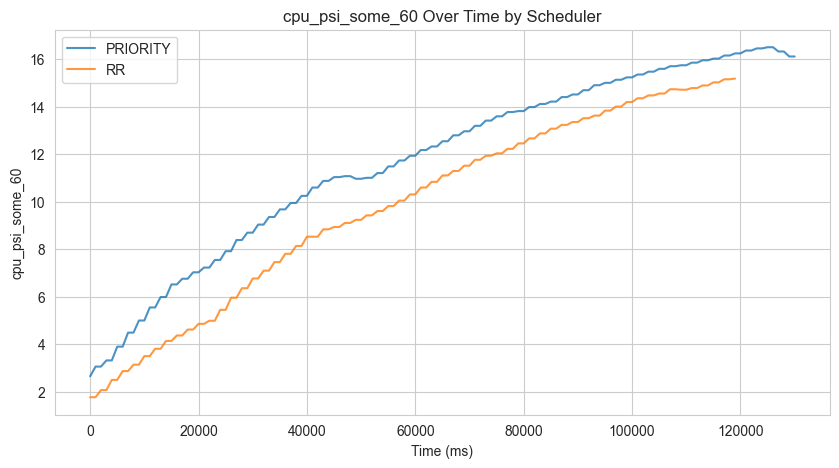

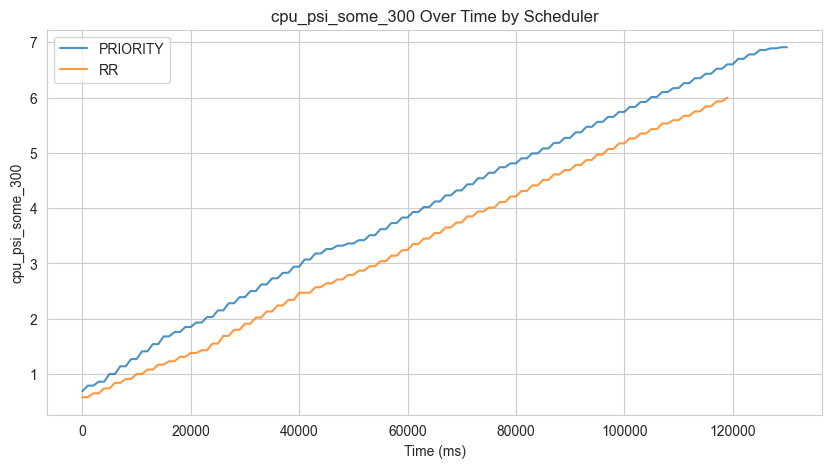

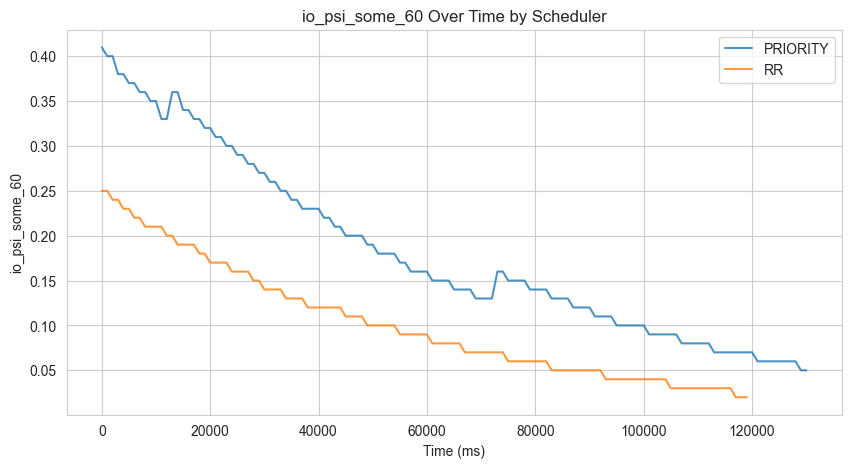

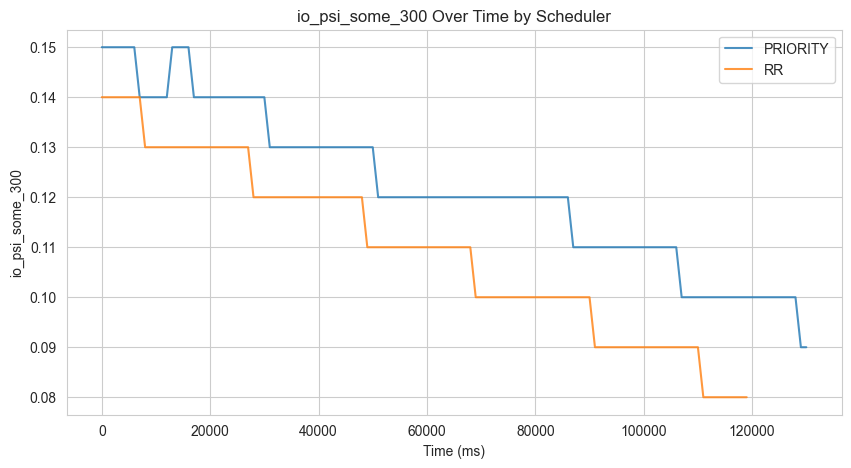

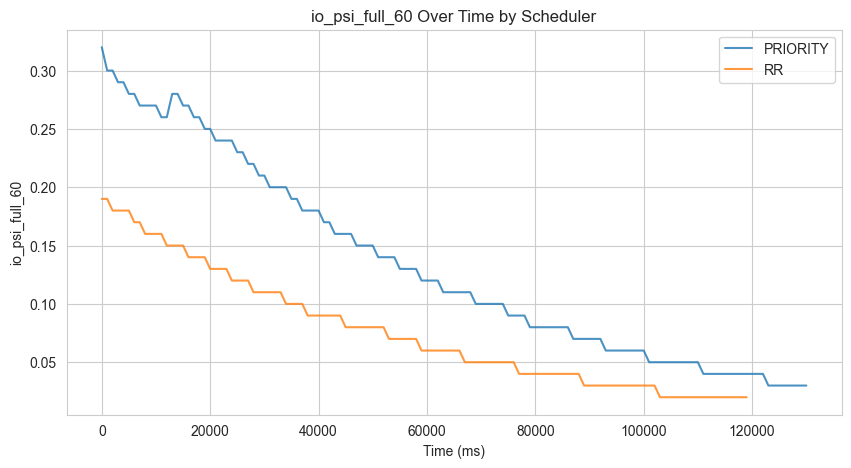

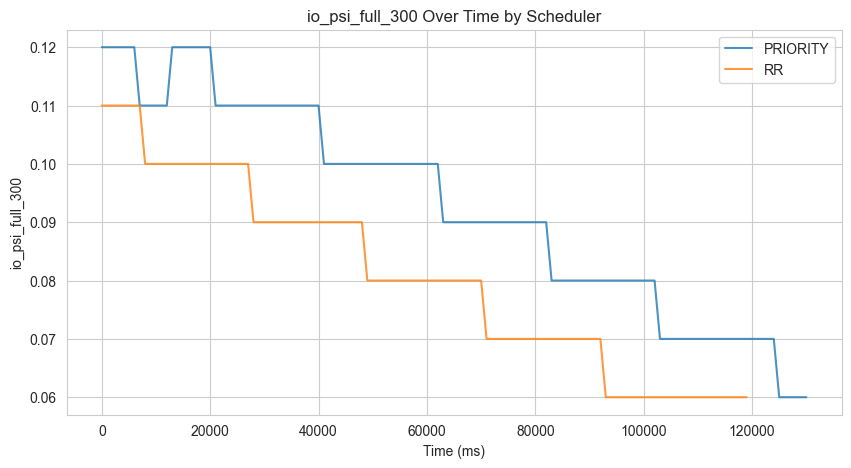

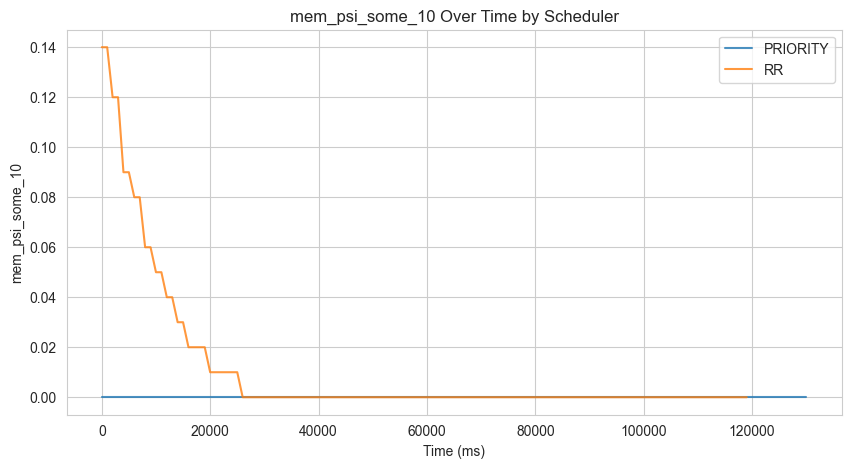

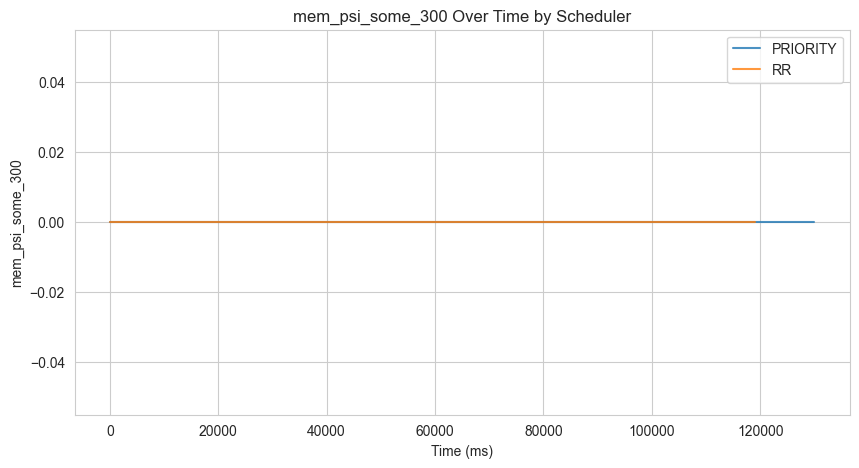

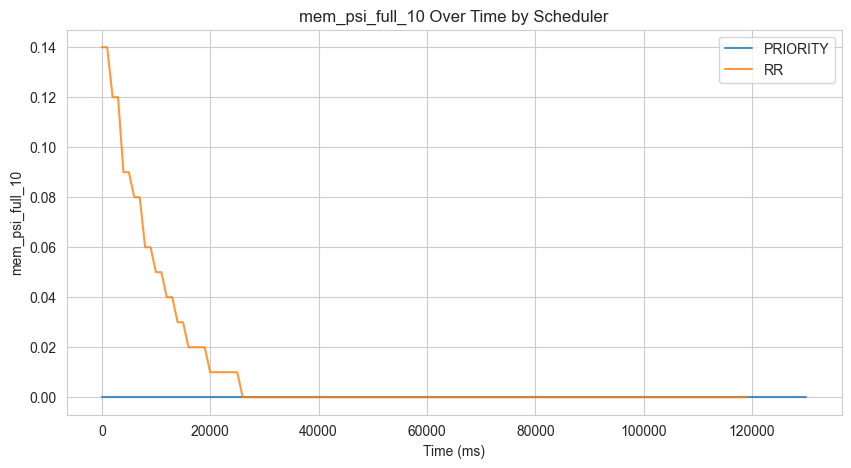

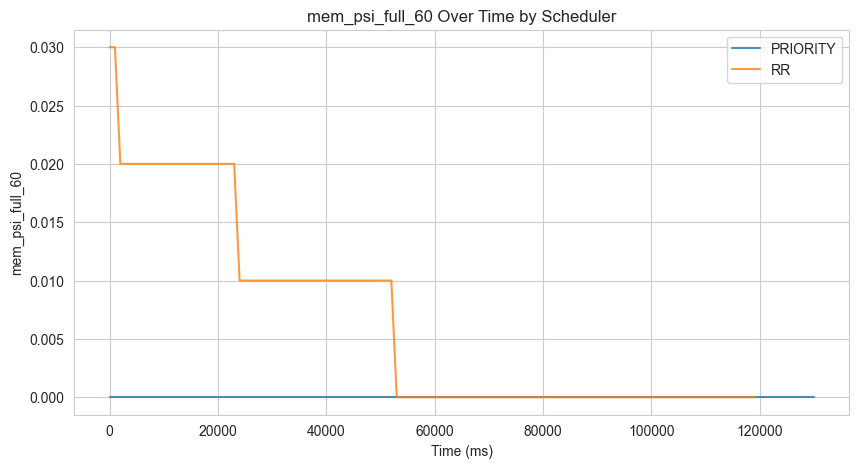

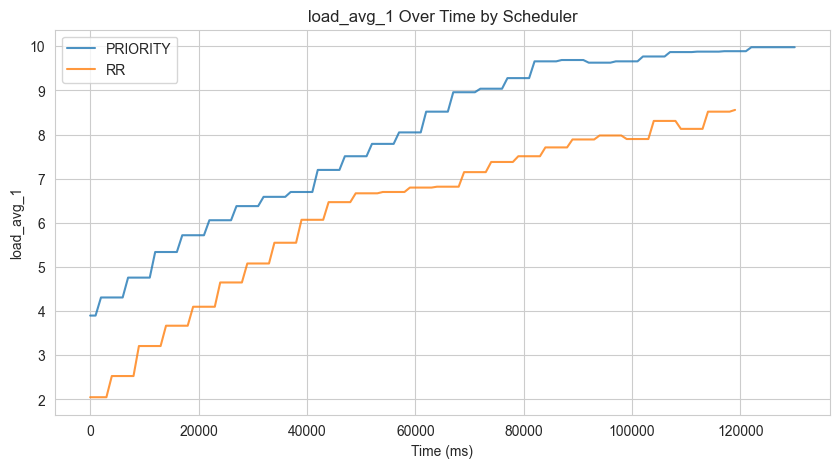

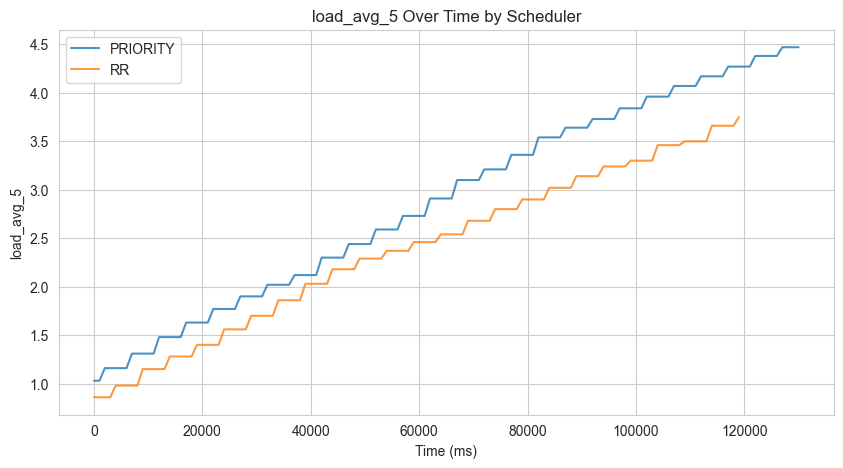

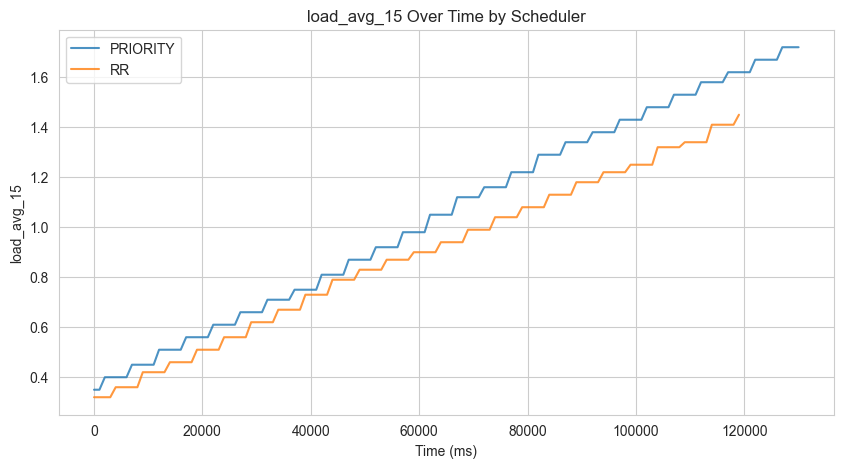

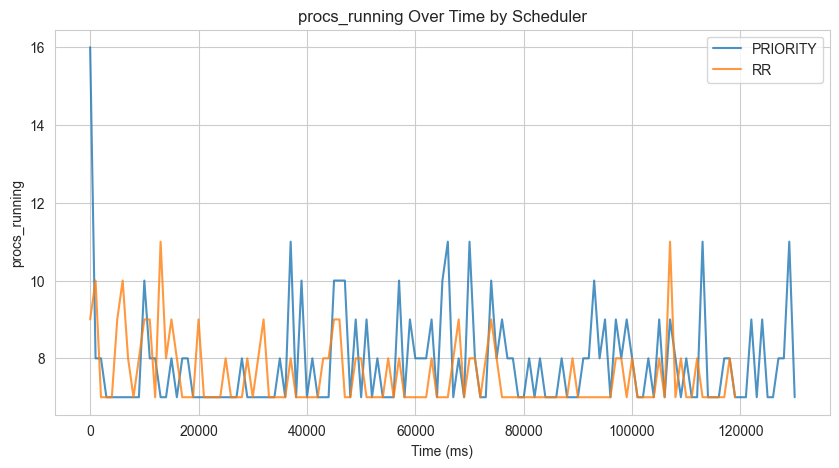

In [14]:
# Line graph of every metric with respect to time_ms

for col in metrics:
    plt.figure(figsize=(10,5))
    
    for sched in df["scheduler"].unique():
        sub = df[df["scheduler"] == sched]
        plt.plot(sub["time_ms"], sub[col], label=sched, alpha=0.8)
    
    plt.title(f"{col} Over Time by Scheduler")
    plt.xlabel("Time (ms)")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()